Crystal Segmentation
====================

This is a test of tools to compute the properties of the interface between the liquid and the crystal.
Since I am interested in the melting rate of a sample surrounded by liquid,
as the blob melts the surface area is going to change.
This means that I will require a normalisation factor to be able to properly compute this melting. 

In [1]:
from sdanalysis import order
from sdanalysis.math_helper import displacement_periodic

from functools import partial
from pathlib import Path
import numpy as np
from sklearn import cluster
import gsd.hoomd
from scipy.spatial import ConvexHull
import pandas as pd
import altair as alt
import numba
import json

This creates a periodic distance algorithm using the minimum image convention
which can be used as the distance metric for the clustering algorithm. 

In [2]:
@numba.autojit
def periodic_distance(box, X, Y):
    element_size = X.shape[0]
    inv_box = 1./box
    x = X - Y
    for j in range(element_size):
        if box[j] > 1e-6:
            images = inv_box[j] * x[j]
            x[j] = box[j] * (images - round(images))

    return np.linalg.norm(x)

In [3]:
data_dir = Path('../data/simulations/melting')
for i in data_dir.glob('*.gsd'):
    Path.cwd
file = data_dir / 'dump-Trimer-P1.00-T0.45-p2.gsd'
with gsd.hoomd.open(str(file)) as src:
    snap = src[-1]

In [4]:
ordering = order.compute_ml_order(order.knn_model(), 
                                  snap.configuration.box, 
                                  snap.particles.position, 
                                  snap.particles.orientation)
ordering = ordering != 'liq'
ordering = np.expand_dims(ordering, axis=1)

In [5]:
learn_matrix = np.append(snap.particles.position, ordering*5, axis=1)

In [8]:
d = partial(periodic_distance, np.append(snap.configuration.box[:3], 10))

In [9]:
indices, labs = cluster.dbscan(learn_matrix, min_samples=4, eps=3, metric=d)

In [10]:
labs.sum()

263

In [11]:
hull = ConvexHull(snap.particles.position[labs==1, :2])
hull.area, hull.volume

(149.47185468423893, 1639.9646053993765)

In [12]:
hull.area, hull.volume

(149.47185468423893, 1639.9646053993765)

In [13]:
df = pd.DataFrame({
    'x': learn_matrix[:, 0],
    'y': learn_matrix[:, 1],
    'z': learn_matrix[:, 2],
    'class': learn_matrix[:, 3],
    'group': labs,
})

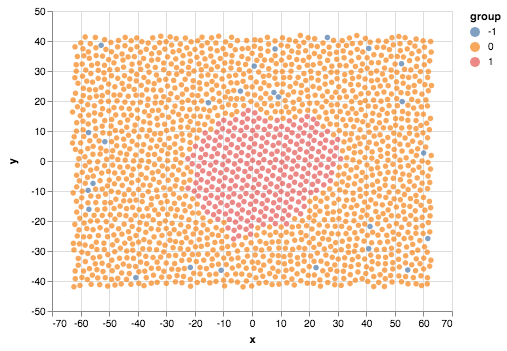

In [14]:
alt.Chart(df).mark_circle().encode(
    x='x',
    y='y',
    color='group:N',
)

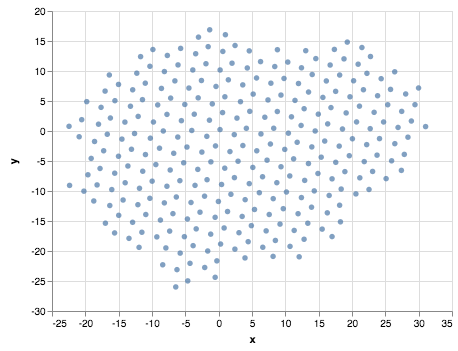

In [15]:
alt.Chart(pd.DataFrame(data=hull.points, columns=['x', 'y'])).mark_circle().encode(
    x='x:Q',
    y='y:Q'
)